# **Project #4 - Food Recognition**
### Deep Learning course - A.Y. 2020-2021
Students:

- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

Install segmentation_models library

In [1]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 7.6MB/s 


Clone the repo in order to access to the dataset

In [2]:
!git clone https://github.com/gmurro/FoodRecognition.git
%cd /content/FoodRecognition/src

/content/FoodRecognition/src


Import useful libraries

In [2]:
import numpy as np
import random
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from utils import segmentation_utils

Define the categories of food on which we want train the segmentation model

In [3]:
cat_names = ['water'
             , 'bread-white'
             , 'salad-leaf-salad-green'
             , 'tomato'
             , 'butter'
             , 'carrot'
             , 'coffee-with-caffeine'
             , 'rice'
             , 'egg'
             , 'mixed-vegetables'
             , 'wine-red'
             , 'apple'
             , 'jam'
             , 'potatoes-steamed'
             , 'banana'
             , 'cheese' ]
             
batch_size = 64
img_size = (128,128)
num_classes = len(cat_names) + 1
num_filters = 32

Define the class `DataGenerator`, which will be used for real-time data feeding to our Keras model.
We make the latter inherit the properties of `keras.utils.Sequence` so that we can leverage nice functionalities such as *multiprocessing*.

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, coco, batch_size, img_size, img_ids, img_paths, cat_to_label, aug_args=None, shuffle=True):
        self.coco = coco
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.img_ids = img_ids
        self.cat_to_label = cat_to_label
        self.aug_args = aug_args
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """ Number of batches per epoch """
        return len(self.img_ids) // self.batch_size

    def __getitem__(self, idx):
        """ Generate one batch of data """

        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # n of categories
        n_cat = len(self.cat_to_label)

        # Find list of img paths and image ids to read in the batch
        batch_img_paths = [self.img_paths[i] for i in indexes]
        batch_img_ids = [self.img_ids[i] for i in indexes]

        # load imgs
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.float32)
        for j, path in enumerate(batch_img_paths):
            img = img_to_array(load_img(path, target_size=self.img_size))
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size + (n_cat,), dtype=np.float32)
        for j, img_id in enumerate(batch_img_ids):
            mask = segmentation_utils.load_mask(self.coco, img_id, self.cat_to_label)

            # scale down mask
            mask_scaled = np.zeros(self.img_size+ (n_cat,), dtype=np.uint8)
            for i in range(n_cat):
                mask_scaled[:,:,i] = Image.fromarray(mask[:,:,i]).resize(self.img_size, Image.NEAREST)

            y[j] = np.array(mask_scaled, dtype=np.float32)
            
        if self.aug_args is not None:
            x, y = segmentation_utils.augment(x, y, self.aug_args)
            
            #
            
        return x, y

    def on_epoch_end(self):
        """ Method called at the end of every epoch that updates indexes """
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

Test if the DataGenerator works well

In [ ]:
# @title Test of the DataGenerator
path_dir = "../data/val/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# parameters for the augmetation
aug_args = dict(
                  rotation_range=5              # @param {type:"slider", min:0, max:10, step:1}
                , width_shift_range=0.01        # @param {type:"slider", min:0, max:0.1, step:0.01}
                , height_shift_range=0.01       # @param {type:"slider", min:0, max:0.1, step:0.01}
                , shear_range=0.01              # @param {type:"slider", min:0, max:0.1, step:0.01}
                , zoom_range=[0.9, 1]           
                , horizontal_flip=True          # @param {type:"boolean"} 
                , vertical_flip=True            # @param {type:"boolean"} 
                , fill_mode='nearest'          #@param ["constant", "nearest", "reflect", "wrap"] {type:"raw"}
                , data_format='channels_last')

# create the generator with augmemtation
data_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths, cat_to_label, aug_args)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
# read a batch from the generator
data= data_gen.__getitem__(0)
x = data[0]
y  = data[1]

print("x shape:",x.shape)
print("y shape:",y.shape)

x shape: (32, 128, 128, 3)
y shape: (32, 128, 128, 17)



Image 18


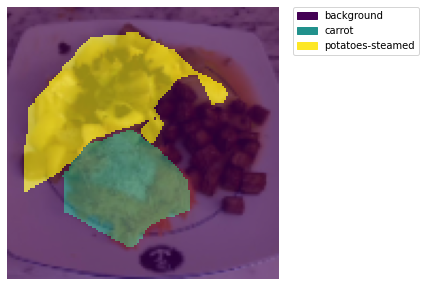


Image 19


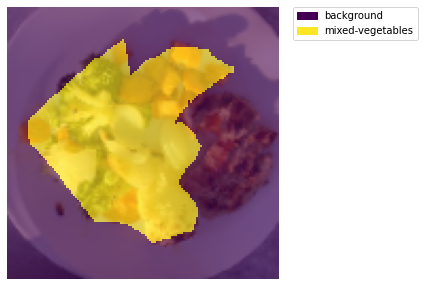


Image 20


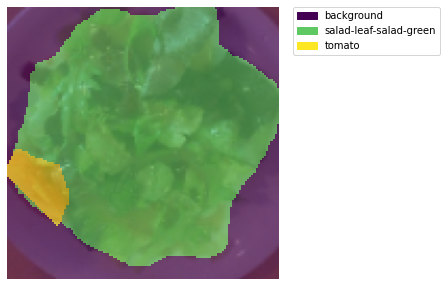

In [ ]:
# read 3 random image from the batches
n = 3

idx = np.random.randint(0, batch_size-1-n)

for i in range(idx,idx+n):
    print("\nImage {}".format(i))
    segmentation_utils.show_mask(x[i,:,:,:]/255, y[i,:,:,:], cat_names)

Test load data without DataGenerator

In [ ]:
# LOAD ALL DATA
x, y = segmentation_utils.load_data(coco, path_dir+"images/", img_size, cat_names)

Loading images:
553/554 [============================>.] - ETA: 0s
Loading masks:
553/554 [============================>.] - ETA: 0s


Image 98


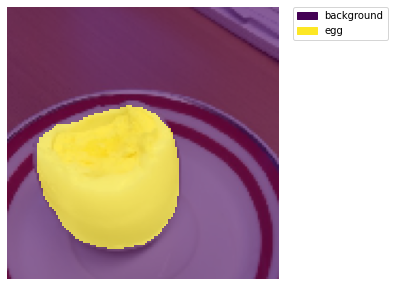

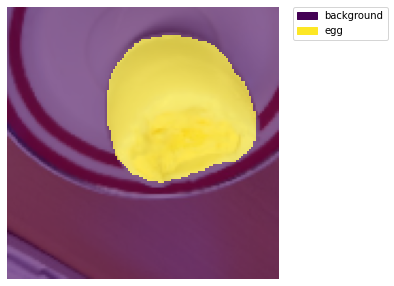


Image 99


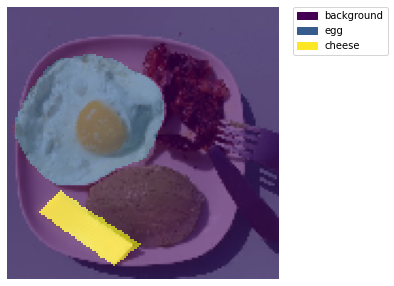

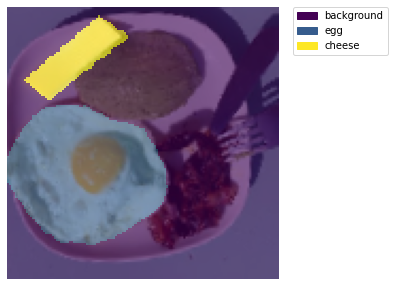


Image 100


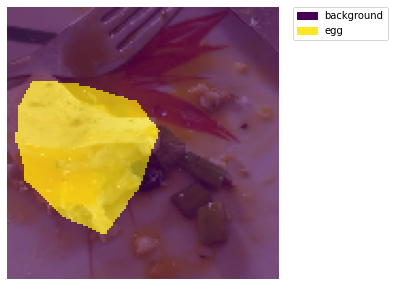

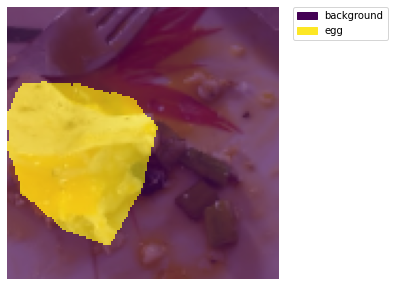

In [ ]:
# show 3 random image and compare with augmentation
n = 3

idx = random.randint(0, len(x)-1-n)

for i in range(idx,idx+n):
    print("\nImage {}".format(i))

    # show image not augmented
    segmentation_utils.show_mask(x[i,:,:]/255, y[i,:,:,:], cat_names)

    # show the same image augmented
    x_p = x[i].reshape((1,)+x[i].shape)
    y_p = y[i].reshape((1,)+y[i].shape)
    x_aug, y_aug = segmentation_utils.augment(x_p, y_p, aug_args)
    segmentation_utils.show_mask(x_aug[0,:,:]/255, y_aug[0,:,:,:], cat_names)

My Custom U-Net

In [14]:
from tensorflow.keras import layers

def conv_block(input, num_filters, size=3, padding='same', initializer="he_normal"):
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def deconv_block(input, num_filters, skip_features, size=2, padding='same', strides=(2, 2)):
    x = layers.Conv2DTranspose(num_filters, kernel_size=(size, size), strides=strides, padding=padding)(input)
    x = layers.concatenate([x, skip_features], axis=3)
    x = conv_block(x, num_filters)
    return x

def unet(img_size, num_classes, num_filters=64):
    
    ''' Input layer '''
    input_layer = layers.Input(shape=img_size + (3,), name='image_input')
    # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalization
    
    ''' Contractive path '''
    ### Layer 1
    conv1 = conv_block(input_layer, num_filters=num_filters)
    conv1_out = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    ### Layer 2
    conv2 = conv_block(conv1_out, num_filters=num_filters*2)
    conv2_out = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    ### Layer 3
    conv3 = conv_block(conv2_out, num_filters=num_filters*4)
    conv3_out = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    ### Layer 4
    conv4 = conv_block(conv3_out, num_filters=num_filters*8)
    conv4_out = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = layers.Dropout(0.5)(conv4_out)
    
    ### Layer 5
    conv5 = conv_block(conv4_out, num_filters=num_filters*16)
    conv5 = layers.Dropout(0.5)(conv5)
    
    ''' Expansive path '''
    ### Layer 6
    deconv6 = deconv_block(conv5, num_filters=num_filters*8, skip_features=conv4)
    deconv6 = layers.Dropout(0.5)(deconv6)
    
    ### Layer 7
    deconv7 = deconv_block(deconv6, num_filters=num_filters*4, skip_features=conv3,)
    
    ### Layer 8
    deconv8 = deconv_block(deconv7, num_filters=num_filters*2, skip_features=conv2)
    
    ### Layer 9
    deconv9 = deconv_block(deconv8, num_filters=num_filters, skip_features=conv1)
    
    # output: add a per-pixel classification layer
    output_layer = layers.Conv2D(filters=num_classes, kernel_size=(1, 1), activation="sigmoid", padding="same")(deconv9)
    
    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='u-net')
    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = unet(img_size, num_classes, num_filters=num_filters)
model.summary()

Model: "u-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

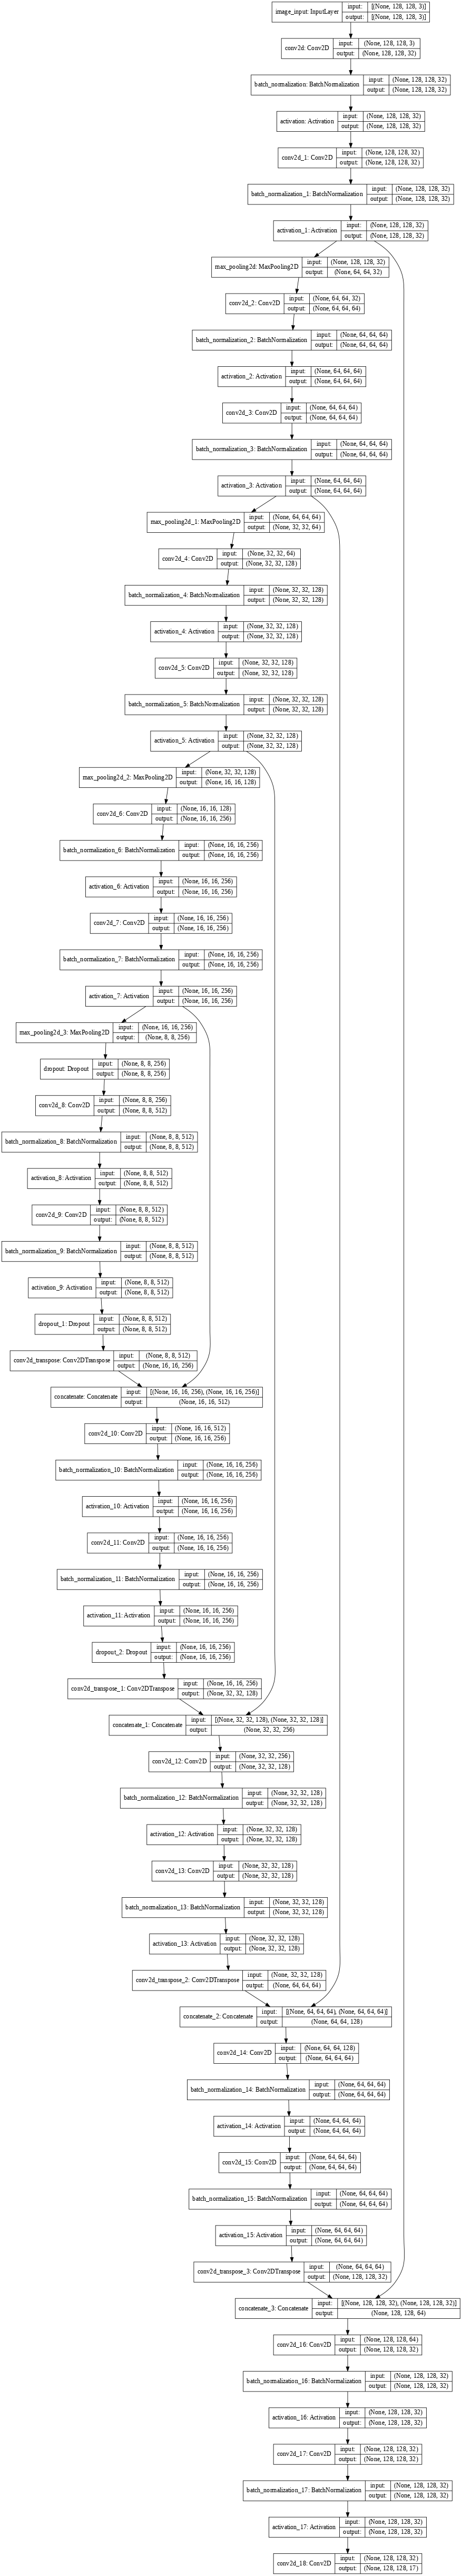

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

Instantiate data Generators for training and validation set

In [6]:
# @title DataGenerator fro training set
path_dir = "../data/train/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

# compute the class weights
class_dist = segmentation_utils.get_class_dist(coco, cat_names)
class_weights = segmentation_utils.get_class_weights(class_dist)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# parameters for the augmetation
aug_args = dict(
                  rotation_range=5              # @param {type:"slider", min:0, max:10, step:1}
                , width_shift_range=0.01        # @param {type:"slider", min:0, max:0.1, step:0.01}
                , height_shift_range=0.01       # @param {type:"slider", min:0, max:0.1, step:0.01}
                , brightness_range=(0.8, 1.2)  
                , shear_range=0.01              # @param {type:"slider", min:0, max:0.1, step:0.01}
                , zoom_range=[0.7, 1]           
                , horizontal_flip=True          # @param {type:"boolean"} 
                , vertical_flip=True            # @param {type:"boolean"} 
                , fill_mode='constant'          #@param ["constant", "nearest", "reflect", "wrap"] {type:"raw"}
                , data_format='channels_last')

# create the generator
train_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths,  cat_to_label, aug_args)

loading annotations into memory...
Done (t=1.86s)
creating index...
index created!


In [7]:
class_weights

array([0.05882353, 0.3468184 , 1.01663221, 0.63136088, 0.49993069,
       1.26775252, 1.26272176, 1.57527665, 0.71266715, 0.53524959,
       1.54468875, 1.01989065, 0.59533374, 1.16772801, 0.96572347,
       0.72649745, 1.41424837])

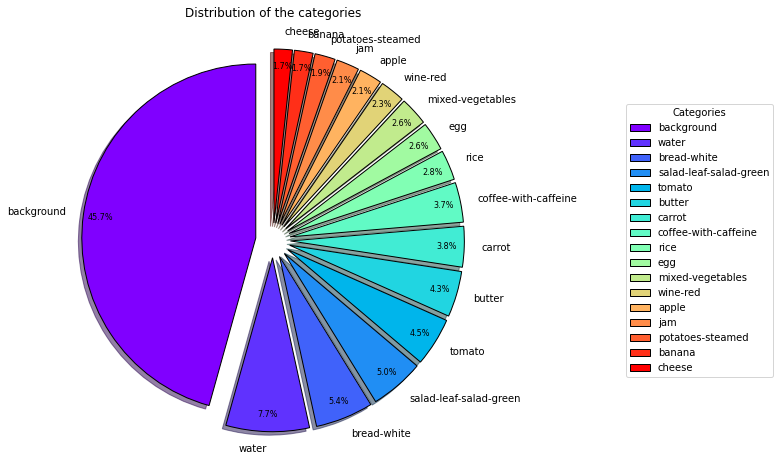

In [8]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

# sort class_distr
class_dist_sorted = dict(sorted(class_dist.items(), key=lambda x:x[1], reverse=True))

# set data
labels = [cat_names[cat_to_label[cat_id]] for cat_id in class_dist_sorted.keys()]
data = list(class_dist_sorted.values())
  
#colors
colors = cm.rainbow(np.linspace(0, 1, len(class_dist_sorted)))

#explsion
explode = [0.1]*len(class_dist_sorted)
  
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
  
  
# Creating plot
fig, ax = plt.subplots(figsize =(12, 8))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct='%1.1f%%',
                                  pctdistance=0.9,
                                  explode = explode, 
                                  labels = labels,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp
                                  )
  
# Adding legend
ax.legend(wedges, labels,
          title ="Categories",
          loc ="center left",
          bbox_to_anchor =(1.3, 0, 0.5, 1))
  
plt.setp(autotexts, size = 8)
ax.set_title("Distribution of the categories")

# show plot
plt.show()

In [9]:
# @title DataGenerator fro training set
path_dir = "../data/val/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# create the generator
val_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths, cat_to_label)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [10]:
%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm

loss = sm.losses.BinaryFocalLoss() + sm.losses.DiceLoss(class_weights=class_weights)

#loss = sm.losses.categorical_focal_loss

threshold = 0.5
metrics = [tf.keras.metrics.MeanIoU(num_classes=num_classes)
           , sm.metrics.IOUScore(threshold=threshold)
           , sm.metrics.Precision(threshold=threshold)
           , sm.metrics.Recall(threshold=threshold)
           , sm.metrics.FScore(threshold=threshold)]

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [15]:
# Configure the model for training.
from tensorflow.keras.optimizers import *
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
              , loss=loss
              , metrics=metrics)

In [12]:
weights = dict(zip(range(len(cat_names)), class_weights))
weights

{0: 0.058823529411764705,
 1: 0.34681840038467704,
 2: 1.0166322119902274,
 3: 0.6313608776844071,
 4: 0.4999306871216672,
 5: 1.267752519334427,
 6: 1.2627217553688141,
 7: 1.57527664531159,
 8: 0.7126671497266319,
 9: 0.5352495918468313,
 10: 1.5446887492861223,
 11: 1.019890648567119,
 12: 0.5953337368623782,
 13: 1.1677280086346464,
 14: 0.9657234669285013,
 15: 0.7264974482943862,
 16: 1.4142483660130718}

In [16]:
import datetime
cp_file_name = "model/food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +".h5"

callbacks = [
    #Model checkpoint save weights ad other informations
    tf.keras.callbacks.ModelCheckpoint(cp_file_name, 
                                       monitor = 'loss', # Select which quantity to refers, can also use metrics or the validation 
                                      verbose = 1,
                                      save_best_only = True, 
                                      mode = 'auto', 
                                      save_freq = 'epoch' # Flag to save at each epoch 
                                      )
    , tf.keras.callbacks.TensorBoard(log_dir="model/logs/tensorboard_logs_focal_dice_50_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
]

# Train the model, doing validation at the end of each epoch.
epochs = 80
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/80
169/169 [==============================] - 1017s 6s/step - loss: 1.0452 - mean_io_u: 0.4704 - iou_score: 0.0488 - precision: 0.1301 - recall: 0.2214 - f1-score: 0.0740 - val_loss: 1.0155 - val_mean_io_u: 0.4703 - val_iou_score: 0.0411 - val_precision: 0.1004 - val_recall: 0.2417 - val_f1-score: 0.0731

Epoch 00001: loss improved from inf to 1.00940, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h5
Epoch 2/80
169/169 [==============================] - 982s 6s/step - loss: 0.9619 - mean_io_u: 0.4703 - iou_score: 0.1092 - precision: 0.2835 - recall: 0.2211 - f1-score: 0.1617 - val_loss: 1.1484 - val_mean_io_u: 0.4820 - val_iou_score: 0.0354 - val_precision: 0.1709 - val_recall: 0.1332 - val_f1-score: 0.0622

Epoch 00002: loss improved from 1.00940 to 0.94994, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h5
Epo


Epoch 00017: loss improved from 0.77599 to 0.76491, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h5
Epoch 18/80
169/169 [==============================] - 966s 6s/step - loss: 0.7724 - mean_io_u: 0.4703 - iou_score: 0.2404 - precision: 0.3766 - recall: 0.4073 - f1-score: 0.3525 - val_loss: 0.8197 - val_mean_io_u: 0.4703 - val_iou_score: 0.1924 - val_precision: 0.3685 - val_recall: 0.3211 - val_f1-score: 0.2844

Epoch 00018: loss did not improve from 0.76491
Epoch 19/80
169/169 [==============================] - 978s 6s/step - loss: 0.7532 - mean_io_u: 0.4703 - iou_score: 0.2543 - precision: 0.3920 - recall: 0.4252 - f1-score: 0.3711 - val_loss: 0.7951 - val_mean_io_u: 0.4703 - val_iou_score: 0.2160 - val_precision: 0.3809 - val_recall: 0.3612 - val_f1-score: 0.3160

Epoch 00019: loss improved from 0.76491 to 0.75258, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128


Epoch 00034: loss improved from 0.67316 to 0.66763, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h5
Epoch 35/80
169/169 [==============================] - 1009s 6s/step - loss: 0.6592 - mean_io_u: 0.4703 - iou_score: 0.3373 - precision: 0.5038 - recall: 0.4995 - f1-score: 0.4634 - val_loss: 0.7083 - val_mean_io_u: 0.4703 - val_iou_score: 0.2958 - val_precision: 0.4794 - val_recall: 0.4305 - val_f1-score: 0.4125

Epoch 00035: loss improved from 0.66763 to 0.65935, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h5
Epoch 36/80
169/169 [==============================] - 968s 6s/step - loss: 0.6672 - mean_io_u: 0.4704 - iou_score: 0.3346 - precision: 0.4998 - recall: 0.4970 - f1-score: 0.4575 - val_loss: 0.7102 - val_mean_io_u: 0.4703 - val_iou_score: 0.2944 - val_precision: 0.5158 - val_recall: 0.4067 - val_f1-score: 0.40

Epoch 52/80
169/169 [==============================] - 963s 6s/step - loss: 0.6091 - mean_io_u: 0.4703 - iou_score: 0.3875 - precision: 0.5542 - recall: 0.5452 - f1-score: 0.5147 - val_loss: 0.6580 - val_mean_io_u: 0.4703 - val_iou_score: 0.3450 - val_precision: 0.5397 - val_recall: 0.4703 - val_f1-score: 0.4575

Epoch 00052: loss improved from 0.60615 to 0.60267, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h5
Epoch 53/80
169/169 [==============================] - 965s 6s/step - loss: 0.6003 - mean_io_u: 0.4704 - iou_score: 0.3974 - precision: 0.5663 - recall: 0.5600 - f1-score: 0.5246 - val_loss: 0.6824 - val_mean_io_u: 0.4704 - val_iou_score: 0.3338 - val_precision: 0.5975 - val_recall: 0.4459 - val_f1-score: 0.4396

Epoch 00053: loss improved from 0.60267 to 0.59668, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h


Epoch 00070: loss did not improve from 0.56318
Epoch 71/80
169/169 [==============================] - 963s 6s/step - loss: 0.5586 - mean_io_u: 0.4703 - iou_score: 0.4364 - precision: 0.6061 - recall: 0.5975 - f1-score: 0.5646 - val_loss: 0.5858 - val_mean_io_u: 0.4704 - val_iou_score: 0.4110 - val_precision: 0.5970 - val_recall: 0.5244 - val_f1-score: 0.5324

Epoch 00071: loss improved from 0.56318 to 0.55819, saving model to model\food_segmentation_50_epochs_sigmoid_binary_focal_dice_loss_128_class_weights_adam_32_filters_20210606-114504.h5
Epoch 72/80
169/169 [==============================] - 961s 6s/step - loss: 0.5630 - mean_io_u: 0.4703 - iou_score: 0.4400 - precision: 0.6050 - recall: 0.6001 - f1-score: 0.5644 - val_loss: 0.6318 - val_mean_io_u: 0.4703 - val_iou_score: 0.3647 - val_precision: 0.6161 - val_recall: 0.4962 - val_f1-score: 0.4793

Epoch 00072: loss did not improve from 0.55819
Epoch 73/80
169/169 [==============================] - 969s 6s/step - loss: 0.5560 - mean

In [17]:
import matplotlib.pyplot as plt
def plot_history(model_history, keys, labels=("epochs", "metrics"), figsize=(10,5)):
    
    fig = plt.figure(figsize=figsize)
    
    # take all pairs of training and val metrics
    for i in range(0, len(keys), 2):
        m, val_m = keys[i], keys[i+1]
        
        plt.plot(model_history.history[m])
        plt.plot(model_history.history[val_m])
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Adding legend
    plt.legend(keys,
          title ="Legend",
          loc ="upper left",
          bbox_to_anchor =(1.0, 0, 0.5, 1))
    plt.title("Training history")
    plt.grid(True)
    plt.show()

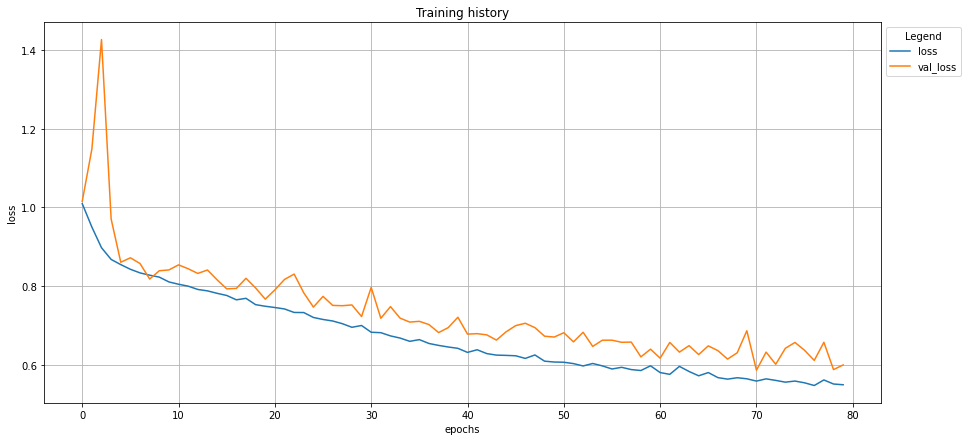

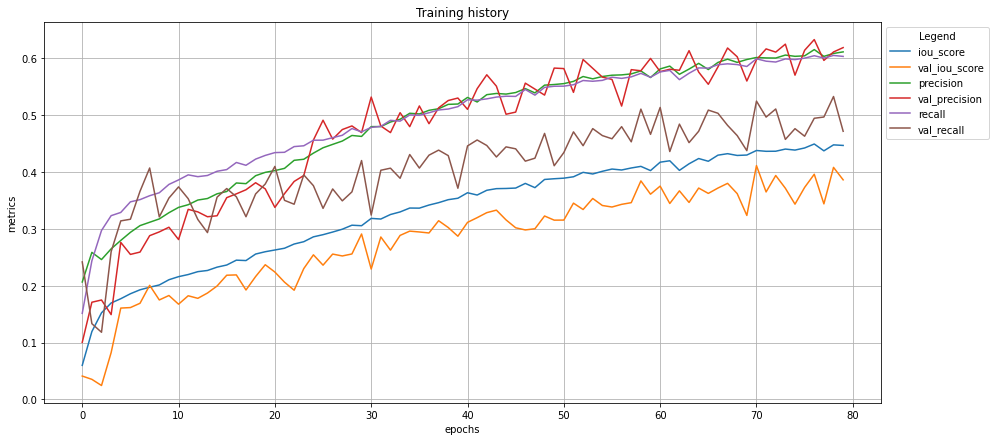

In [21]:
# fit from 0 to 80
plot_history(history,['loss','val_loss'], labels=("epochs", "loss"), figsize=(15,7))
plot_history(history,['iou_score','val_iou_score', 'precision', 'val_precision', 'recall', 'val_recall'], figsize=(15,7))

In [23]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
with open('hist.csv', mode='w') as f:
    hist_df.to_csv(f)

In [31]:
# serialize weights to HDF5
model.save_weights("model_80.h5")

In [ ]:
# if you have pretrained weights, load them here
model.load_weights('model/food_segmentation_focal_60_epochs_20210601-003937.h5')

In [24]:
# LOAD VAL DATA
x, y = segmentation_utils.load_data(coco, "../data/val/images/", img_size, cat_names)

Loading images:
546/554 [============================>.] - ETA: 0s
Loading masks:
552/554 [============================>.] - ETA: 0s

In [25]:
val_preds = model.predict(x)

In [ ]:
from keras import backend as K

smooth = 1e-5

def dice_coef(y_true, y_pred):
    y_true = y_true.astype('float32')
    y_pred = y_pred.astype('float32')
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [26]:
def display_mask(i, size=img_size):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(size)
    display(img)
    print(img.size)

def get_pred_mask(pred):
   mask = np.argmax(pred, axis=-1)
   return mask
def binarize(pred, thresold):
   return np.where(pred > thresold, 1., 0.)

In [ ]:
class_weights

array([0.05882353, 0.33253301, 1.08627451, 0.69336671, 0.50135747,
       1.30352941, 0.85758514, 1.48128342, 0.83559578, 0.50919118,
       1.16386555, 0.95847751, 0.62669683, 1.4168798 , 1.12373225,
       0.77591036, 1.30352941])

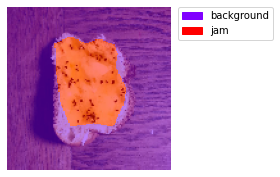

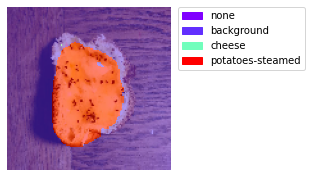

IOU score:  tf.Tensor(0.6143447607029687, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.31315243, shape=(), dtype=float32)
--------------------------------------------------------------


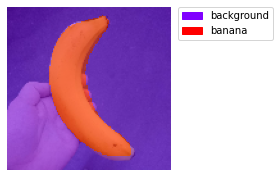

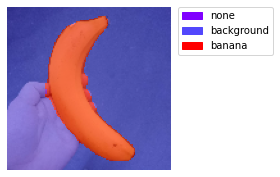

IOU score:  tf.Tensor(0.9515198382300162, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.119986475, shape=(), dtype=float32)
--------------------------------------------------------------


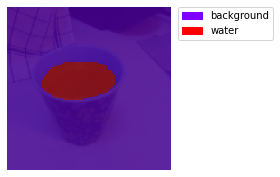

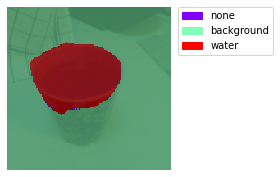

IOU score:  tf.Tensor(0.8302831396616326, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.18124795, shape=(), dtype=float32)
--------------------------------------------------------------


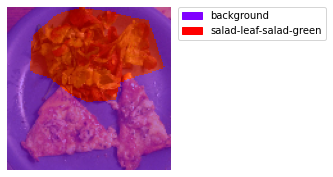

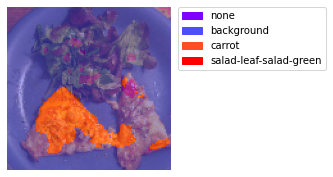

IOU score:  tf.Tensor(0.39624245541263176, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.48779398, shape=(), dtype=float32)
--------------------------------------------------------------


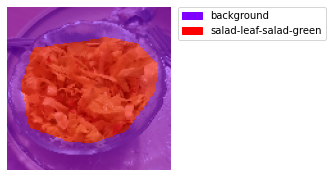

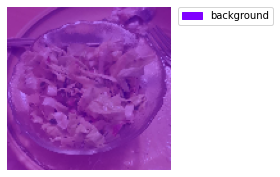

IOU score:  tf.Tensor(0.40641229262783285, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.47844678, shape=(), dtype=float32)
--------------------------------------------------------------


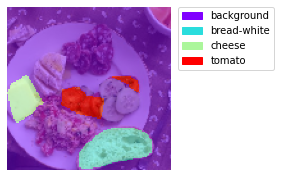

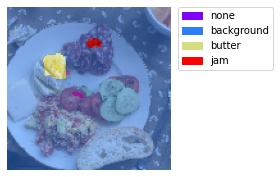

IOU score:  tf.Tensor(0.7007914749879512, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.25632662, shape=(), dtype=float32)
--------------------------------------------------------------


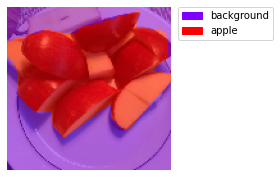

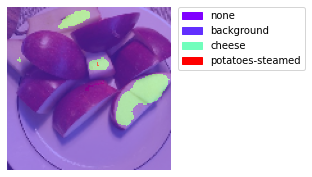

IOU score:  tf.Tensor(0.31940333411769617, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.56307554, shape=(), dtype=float32)
--------------------------------------------------------------


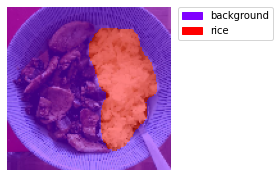

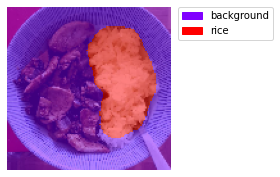

IOU score:  tf.Tensor(0.947077502089217, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.12209654, shape=(), dtype=float32)
--------------------------------------------------------------


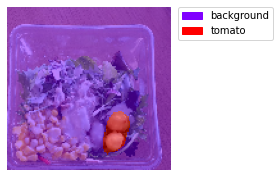

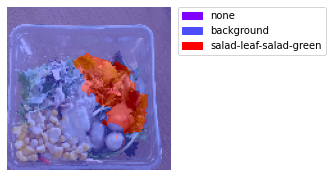

IOU score:  tf.Tensor(0.7745899450902441, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.21219575, shape=(), dtype=float32)
--------------------------------------------------------------


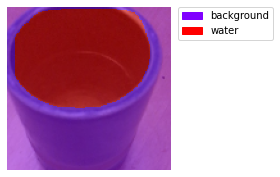

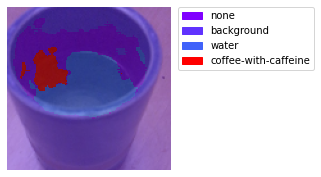

IOU score:  tf.Tensor(0.5811079696402199, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.33665448, shape=(), dtype=float32)
--------------------------------------------------------------


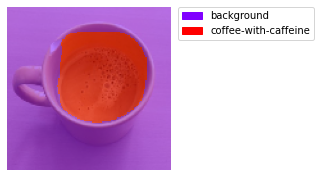

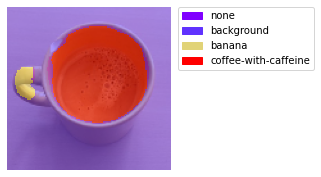

IOU score:  tf.Tensor(0.9076642765324648, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.14124793, shape=(), dtype=float32)
--------------------------------------------------------------


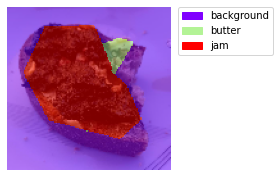

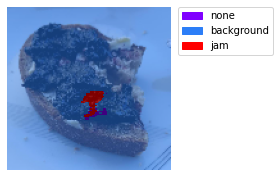

IOU score:  tf.Tensor(0.47210596735034477, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.42117822, shape=(), dtype=float32)
--------------------------------------------------------------


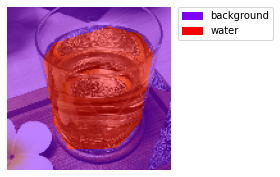

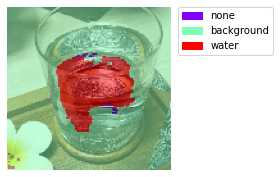

IOU score:  tf.Tensor(0.5804676108667886, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.33711702, shape=(), dtype=float32)
--------------------------------------------------------------


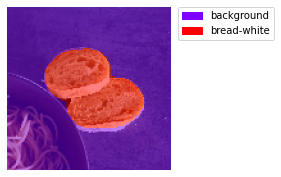

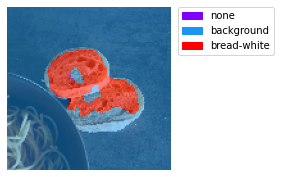

IOU score:  tf.Tensor(0.8435400375352241, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.17415679, shape=(), dtype=float32)
--------------------------------------------------------------


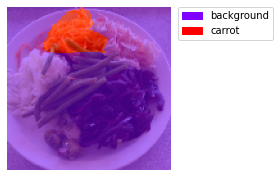

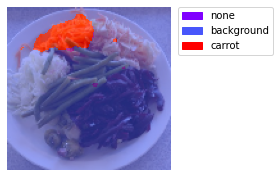

IOU score:  tf.Tensor(0.9335454224498967, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.12858397, shape=(), dtype=float32)
--------------------------------------------------------------


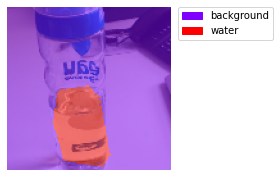

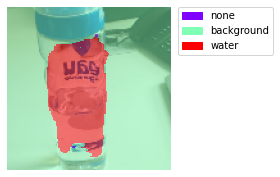

IOU score:  tf.Tensor(0.7771474020269632, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.2107321, shape=(), dtype=float32)
--------------------------------------------------------------


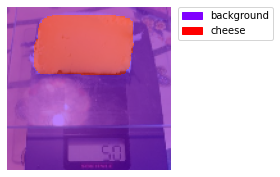

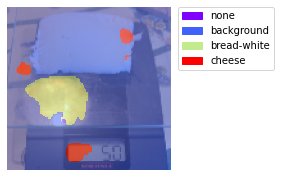

IOU score:  tf.Tensor(0.5624296964930494, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.35030097, shape=(), dtype=float32)
--------------------------------------------------------------


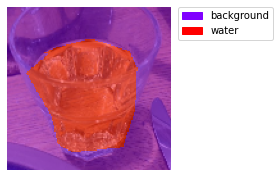

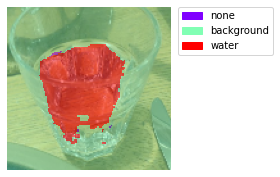

IOU score:  tf.Tensor(0.7012354187620046, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.25604975, shape=(), dtype=float32)
--------------------------------------------------------------


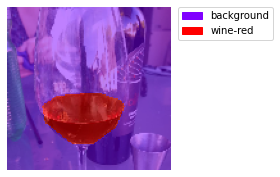

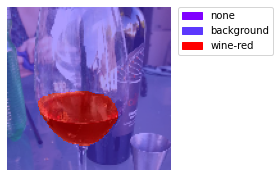

IOU score:  tf.Tensor(0.9616304088204456, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.11521965, shape=(), dtype=float32)
--------------------------------------------------------------


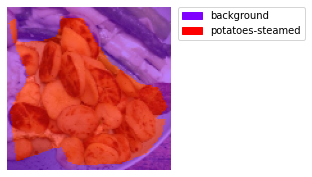

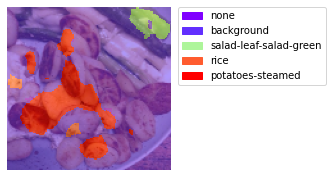

IOU score:  tf.Tensor(0.3466246942028585, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.53542334, shape=(), dtype=float32)
--------------------------------------------------------------


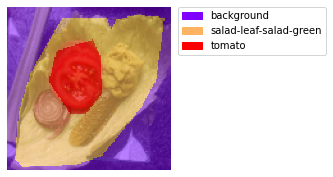

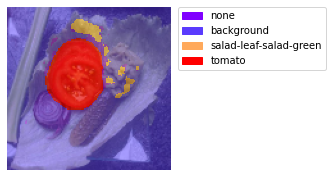

IOU score:  tf.Tensor(0.3281310513019398, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.5540862, shape=(), dtype=float32)
--------------------------------------------------------------


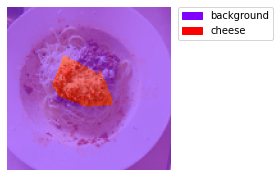

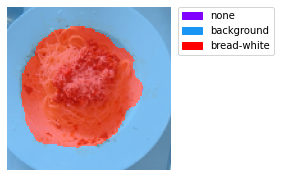

IOU score:  tf.Tensor(0.41178392086407906, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.4735639, shape=(), dtype=float32)
--------------------------------------------------------------


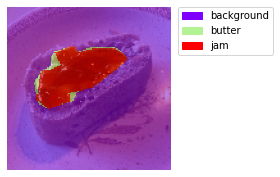

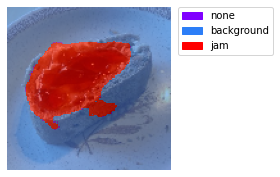

IOU score:  tf.Tensor(0.7473763119703267, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.22803545, shape=(), dtype=float32)
--------------------------------------------------------------


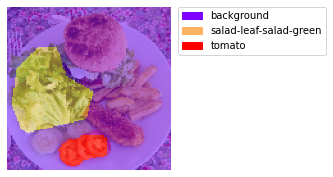

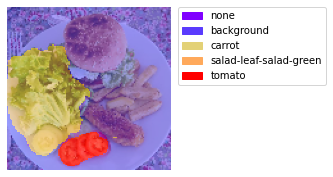

IOU score:  tf.Tensor(0.8444531954070358, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.17367208, shape=(), dtype=float32)
--------------------------------------------------------------


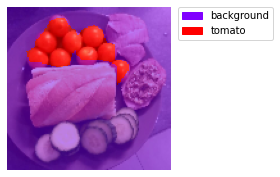

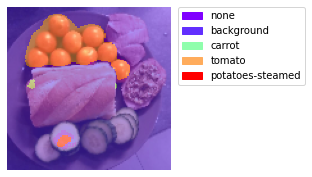

IOU score:  tf.Tensor(0.9285168420854054, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.13101798, shape=(), dtype=float32)
--------------------------------------------------------------


In [33]:
# Display 5 random predictions
n = 25
np.random.seed(2)
idx = np.random.choice(range(len(val_preds)), n)

imgs = [x[i]/255 for i in idx]
masks = [y[i][:,:,0] for i in idx]
predicions = [get_pred_mask(val_preds[i]) for i in idx]

threshold = 0.4
for i in idx:
    
    segmentation_utils.show_mask(x[i]/255, y[i,:,:,:], cat_names, figsize=(3,3))
    segmentation_utils.show_mask(x[i]/255, binarize(val_preds[i], threshold), cat_names, figsize=(3,3))
    print("IOU score: ",sm.metrics.IOUScore().__call__(y[i,:,:,:], binarize(val_preds[i,:,:,:], threshold)))
    print("Dice loss: ",sm.losses.DiceLoss(class_weights=class_weights).__call__(y[i,:,:,:].astype('float32'), binarize(val_preds[i,:,:,:], threshold).astype('float32')))
    print("--------------------------------------------------------------")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir model/logs/tensorboard_logs_20210531-160755

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9020), started 0:03:15 ago. (Use '!kill 9020' to kill it.)

In [ ]:
!taskkill /PID 9020 /F

OPERAZIONE RIUSCITA: il processo con il PID 9020 Š stato terminato.


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir model/logs/tensorboard_logs_60_20210601-003937

Reusing TensorBoard on port 6006 (pid 18460), started 0:03:04 ago. (Use '!kill 18460' to kill it.)

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)